In [139]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [140]:
#### Preprocecing ###

In [141]:
jh_dir = "../../COVID-19"

In [142]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [143]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [144]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [145]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [146]:
### Data Preparation ###

In [147]:
country = 'Japan'
epoch = pd.to_datetime('2020-02-01')
last = pd.to_datetime('2020-04-26')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 12000_0000
iteration=10000
repeat = 1000

In [148]:
data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [149]:
### Model ###

In [150]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f472b1d2ccdff3099b75bd7cdafce0c4 NOW.


In [151]:
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f59a82567eab0aea8cf000ab546b3ce NOW.


In [152]:
# Train the model and generate samples
fit_const = sm_const.sampling(data=data, iter=iteration, init='random')
fit_const


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_f472b1d2ccdff3099b75bd7cdafce0c4.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    18.44    0.02   2.82  13.33  16.47  18.31  20.26  24.33  29514    1.0
b             0.5  4.5e-3    0.6   0.04   0.14   0.29   0.63   2.11  17472    1.0
p            0.32  1.8e-3   0.24   0.04   0.12   0.25   0.46   0.88  16201    1.0
q             1.0  5.8e-6 1.0e-3    1.0    1.0    1.0    1.0    1.0  31205    1.0
NI[1]        1.63  7.8e-3   0.98   0.11   0.88   1.53   2.27   3.78  16089    1.0
NI[2]        1.75  8.0e-3   1.02   0.12   0.97   1.66   2.42   3.95  16248    1.0
NI[3]         2.9  6.2e-3   1.02   1.07   2.16   2.84   3.57   5.04  27578    1.0
NI[4]        1.99  8.8e-3   1.14   0.15   1.12   1.89   2.74   4.45  16788    1.0
NI[5]        2.14  9.0e-3    1.

In [153]:
# Train the model and generate samples
inits = 'random'
fit_every = sm_every.sampling(data=data, iter=iteration, init=inits, control={'adapt_delta':0.99999})
fit_every


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_4f59a82567eab0aea8cf000ab546b3ce.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  11.88    0.02    2.5   7.56   10.1  11.69  13.47  17.27  11911    1.0
b[1]       2.54    0.02   1.62   0.38   1.34   2.23   3.41   6.49   4313    1.0
b[2]        4.5    0.06   2.64   0.72   2.55   4.06   5.97  10.81   1943    1.0
b[3]       6.84     0.1   3.55   1.57   4.23   6.28   8.89  15.19   1237   1.01
b[4]       8.35    0.14   4.37   1.86   5.11    7.7  10.82  18.73    937   1.01
b[5]      10.07    0.18   5.14   2.47   6.27   9.31  12.97  22.19    793   1.01
b[6]      12.08    0.23   5.79   3.47   7.81  11.19  15.37  25.68    620   1.01
b[7]       13.0    0.28   6.47   3.46   8.22  11.96  16.66   28.3    533   1.01
b[8]      14.34    0.33   7.19    3.8    9.1  13.

In [154]:
print(fit_every)

Inference for Stan model: anon_model_4f59a82567eab0aea8cf000ab546b3ce.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     11.88    0.02    2.5   7.56   10.1  11.69  13.47  17.27  11911    1.0
b[1]          2.54    0.02   1.62   0.38   1.34   2.23   3.41   6.49   4313    1.0
b[2]           4.5    0.06   2.64   0.72   2.55   4.06   5.97  10.81   1943    1.0
b[3]          6.84     0.1   3.55   1.57   4.23   6.28   8.89  15.19   1237   1.01
b[4]          8.35    0.14   4.37   1.86   5.11    7.7  10.82  18.73    937   1.01
b[5]         10.07    0.18   5.14   2.47   6.27   9.31  12.97  22.19    793   1.01
b[6]         12.08    0.23   5.79   3.47   7.81  11.19  15.37  25.68    620   1.01
b[7]          13.0    0.28   6.47   3.46   8.22  11.96  16.66   28.3    533   1.01
b[8]         14.34    0.33   7.19    3.8    9.1  13.14  18.45 

In [155]:
# Save models

In [156]:
## Saving results

In [157]:
import pickle
with open("sm_const_fit-Japan.pkl", "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
import pickle
with open("sm_every_fit-Japan.pkl", "wb") as f:
    pickle.dump({'model' : sm_every, 'fit' : fit_every}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
### Load modesl

In [54]:
with open("sm_const_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

In [55]:
with open("sm_every_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_every = data_dict['model']
fit_every = data_dict['fit']
# fit = data_list[1]

In [24]:
### model selection

In [159]:
data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_every = az.from_pystan(fit_every, log_likelihood='log_lik')

In [160]:
loo_const = az.loo(data_const, pointwise=True)
loo_const

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 84 log-likelihood matrix

       Estimate       SE
IC_loo  2646.28   451.66
p_loo    680.85        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       28   33.3%
 (0.5, 0.7]   (ok)         17   20.2%
   (0.7, 1]   (bad)        12   14.3%
   (1, Inf)   (very bad)   27   32.1%

In [161]:
loo_every = az.loo(data_every, pointwise=True)
loo_every

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 84 log-likelihood matrix

       Estimate       SE
IC_loo   633.27    24.13
p_loo     73.05        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        6    7.1%
 (0.5, 0.7]   (ok)          3    3.6%
   (0.7, 1]   (bad)        66   78.6%
   (1, Inf)   (very bad)    9   10.7%

In [162]:
az.compare({'const':data_const, 'everyday':data_every})

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
everyday,0,574.998,43.9079,0,1,630.491,0,True,deviance
const,1,3213.46,964.438,2638.46,3.92378e-221,22.6695,638.333,True,deviance


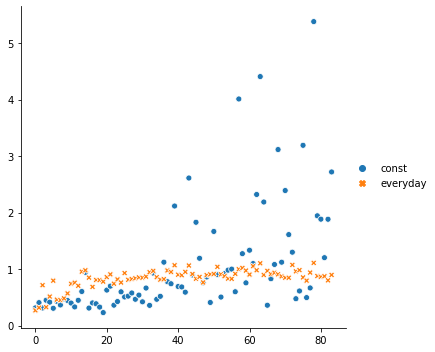

In [163]:
df = pd.DataFrame({'const':loo_const.pareto_k, 'everyday':loo_every.pareto_k})
sns.relplot(data=df)

In [28]:
df.idxmax()

const       63
everyday    63
dtype: int64

In [16]:
def loo(sm):
    log_likelihood = 0
    for i in range(C0.shape[0]-1):
        print('\rNo, %d' % i, end='')
        data_LOO = {'T': C0.shape[0], 'T0': i+1, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
        fit_loo = sm_const.sampling(data=data_LOO, iter=2000, init='random')
        data_loo = az.from_pystan(fit_loo, log_likelihood='log_lik')
        log_likelihood += data_loo.sample_stats['log_likelihood'].sel(log_likelihood_dim_0=i).mean()
        
    return log_likelihood

In [17]:
loo(sm_const)

No, 0

No, 1

No, 3

No, 4

No, 5

No, 6

No, 7

No, 8

No, 9

No, 10

No, 11

No, 12

No, 13

No, 14

No, 15

No, 16

No, 17

No, 18

No, 19

No, 20

No, 23

No, 24

No, 25

No, 27

No, 28

No, 29

No, 30

No, 31

No, 32

No, 33

No, 35

No, 38

No, 39

No, 40

No, 41

No, 44

No, 45

No, 46

No, 47

No, 48

No, 50

No, 51

No, 52

No, 54

No, 55

No, 56

No, 57

No, 58

No, 59

No, 60

No, 62

No, 63

No, 65

No, 69

No, 70

No, 71

No, 72

No, 73

No, 74

No, 75

No, 76

No, 77

<xarray.DataArray 'log_likelihood' ()>
array(-2145.68817238)
Coordinates:
    log_likelihood_dim_0  int64 0

In [18]:
loo(sm_every)

No, 0

No, 2

No, 3

No, 4

No, 5

No, 6

No, 7

No, 8

No, 9

No, 10

No, 12

No, 13

No, 14

No, 15

No, 16

No, 17

No, 18

No, 19

No, 21

No, 22

No, 23

No, 25

No, 26

No, 27

No, 28

No, 29

No, 30

No, 31

No, 32

No, 33

No, 34

No, 36

No, 37

No, 38

No, 41

No, 43

No, 44

No, 45

No, 46

No, 50

No, 51

No, 52

No, 54

No, 55

No, 56

No, 57

No, 59

No, 60

No, 62

No, 63

No, 64

No, 65

No, 66

No, 67

No, 70

No, 71

No, 73

No, 74

No, 77

<xarray.DataArray 'log_likelihood' ()>
array(-2144.49497236)
Coordinates:
    log_likelihood_dim_0  int64 0

In [ ]:
### Visualization ###

In [164]:
def extract(data, upto):
    index=pd.date_range(start=epoch, end=upto)
    init_inf = pd.DataFrame(data_every.posterior['init_inf'].stack(sample=('chain', 'draw')).values)
    b = pd.DataFrame(data_every.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
    q = pd.DataFrame(data_every.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
    NI = pd.DataFrame(data_every.posterior['NI'].stack(sample=('chain', 'draw')).values, index=index)
    a = pd.DataFrame(data_every.posterior['a'].stack(sample=('chain', 'draw')).values)
    d = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
    p = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
    C = NI.cumsum().shift(periods=1)
    NI0 = q*NI
    C0 = NI0.cumsum().shift(periods=1)

    return a, d, p, b, q, NI, NI0, C, C0

In [167]:
a_e, d_e, p_e, b_e, q_e, NI_e, NI0_e, C_e, C0_e = extract(data_every, upto=pd.to_datetime('2020-04-24'))

In [168]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-18')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


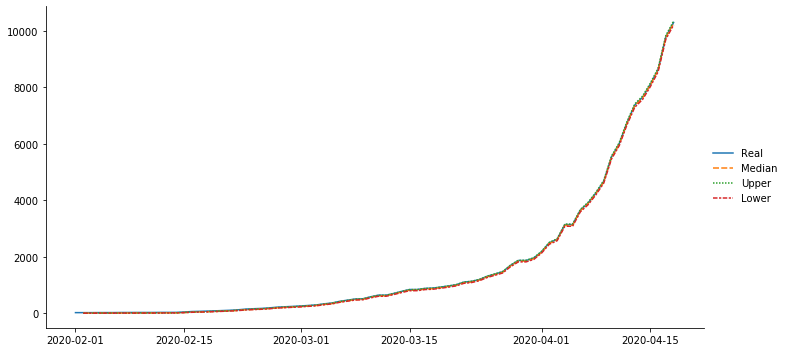

In [169]:
draw(C0_e, real=confirmed[country])

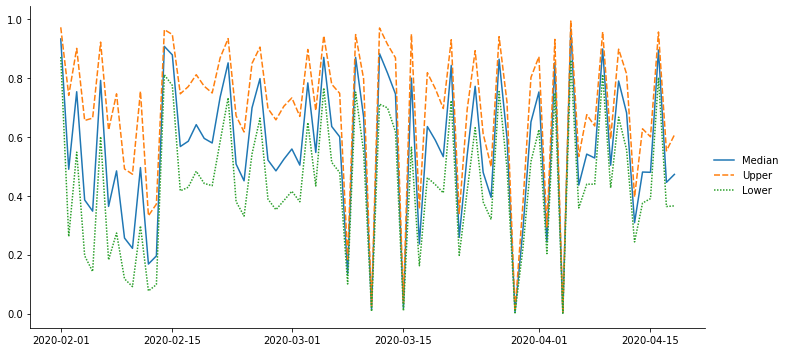

In [170]:
draw(q_e)

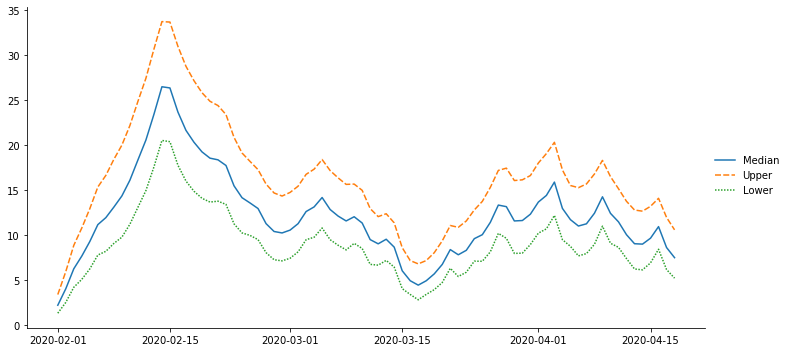

In [171]:
draw(b_e)

In [75]:
b_e.loc[pd.to_datetime('2020-04-01'):].median(axis=1)

2020-04-01    14.224131
2020-04-02    15.005683
2020-04-03    16.569452
2020-04-04    13.611966
2020-04-05    12.377672
2020-04-06    11.712537
2020-04-07    12.021045
2020-04-08    13.183136
2020-04-09    15.109534
2020-04-10    13.087852
2020-04-11    12.182810
2020-04-12    10.929963
2020-04-13     9.910402
2020-04-14     9.860342
2020-04-15    10.614940
2020-04-16    11.954192
2020-04-17    10.313057
2020-04-18     9.573977
Freq: D, dtype: float64

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


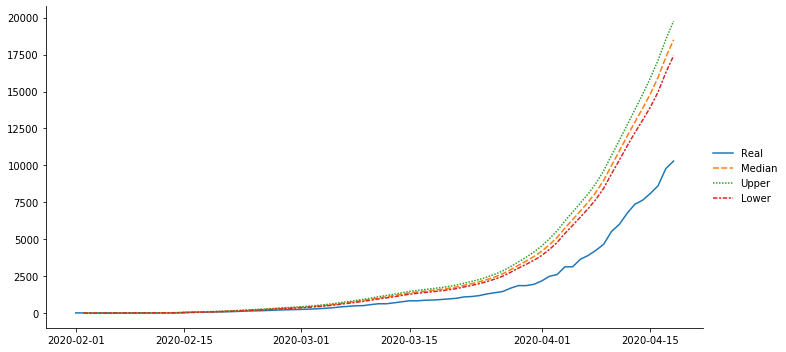

In [172]:
draw(C_e, real=confirmed[country])